In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
stock_name="RELIANCE.NS"
benchmark_symbol="^GSPC"
start_date = "2021-06-01"  
end_date = "2023-06-01"


In [3]:
stock_data=yf.download(stock_name,start_date,end_date)
benchmark_data=yf.download(benchmark_symbol,start_date,end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data.head()
benchmark_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-01,4216.520020,4234.120117,4197.589844,4202.040039,4202.040039,5074670000
2021-06-02,4206.819824,4217.370117,4198.270020,4208.120117,4208.120117,5833670000
2021-06-03,4191.430176,4204.390137,4167.930176,4192.850098,4192.850098,5587970000
2021-06-04,4206.049805,4233.450195,4206.049805,4229.890137,4229.890137,4139790000
2021-06-07,4229.339844,4232.339844,4215.660156,4226.520020,4226.520020,4476920000


In [5]:
window = 10  # Specify the window size for the Donchian Channel
stock_data['high_channel'] = stock_data['High'].rolling(window=window, min_periods=1).max()
stock_data['low_channel'] = stock_data['Low'].rolling(window=window, min_periods=1).min()
signals = []

In [6]:
previous_signal = 0
for i in range(len(stock_data)):
    if stock_data['Close'][i] > stock_data['high_channel'][i-1]:
        if previous_signal != 1:  # Ensure breakout from previous sell signal
            signals.append(1)  # Buy signal
            previous_signal = 1
        else:
            signals.append(0)  # No signal
    elif stock_data['Close'][i] < stock_data['low_channel'][i-1]:
        if previous_signal != -1:  # Ensure breakout from previous buy signal
            signals.append(-1)  # Sell signal
            previous_signal = -1
        else:
            signals.append(0)  # No signal
    else:
        signals.append(0)  # No signal

# Add the trading signals to the DataFrame
stock_data['Signal'] = signals

# Print the DataFrame with the trading signals
print(stock_data)


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2021-06-01  2166.000000  2202.000000  2146.500000  2168.899902  2155.455811   
2021-06-02  2157.000000  2209.500000  2157.000000  2201.250000  2187.605225   
2021-06-03  2221.000000  2250.000000  2196.100098  2209.649902  2195.953125   
2021-06-04  2214.800049  2216.449951  2184.250000  2190.500000  2176.921875   
2021-06-07  2202.000000  2242.000000  2185.000000  2227.399902  2213.593018   
...                 ...          ...          ...          ...          ...   
2023-05-25  2433.899902  2449.000000  2416.050049  2439.949951  2439.949951   
2023-05-26  2458.000000  2509.000000  2450.750000  2506.500000  2506.500000   
2023-05-29  2521.000000  2530.000000  2507.199951  2520.600098  2520.600098   
2023-05-30  2520.600098  2537.699951  2514.350098  2519.949951  2519.949951   
2023-05-31  2500.000000  2509.850098  2461.000000  2

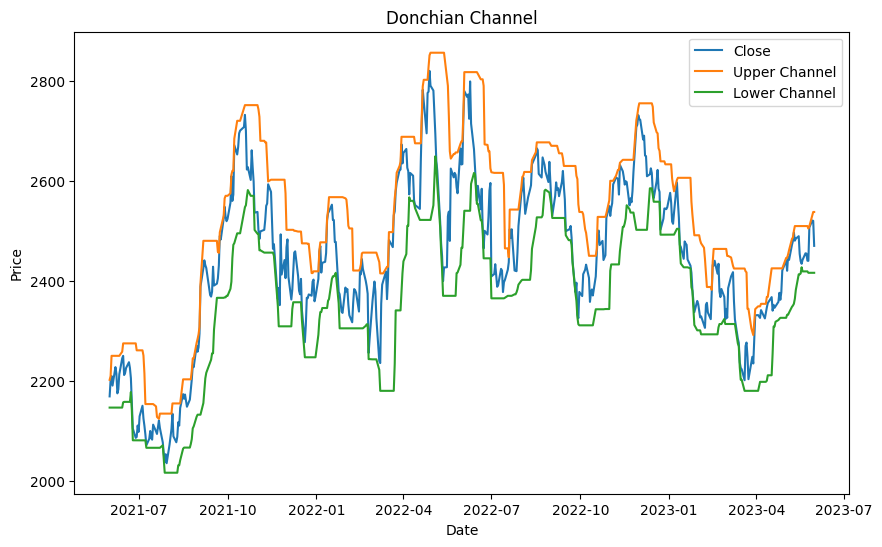

In [7]:
#plotting the dunchian channel indicator
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close')
plt.plot(stock_data.index, stock_data['high_channel'], label='Upper Channel')
plt.plot(stock_data.index, stock_data['low_channel'], label='Lower Channel')
plt.title('Donchian Channel')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


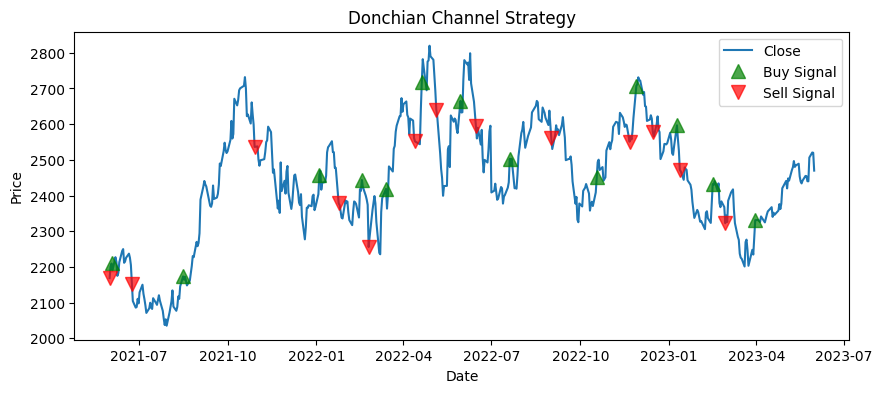

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(stock_data.index, stock_data['Close'], label='Close')
plt.plot(stock_data[stock_data['Signal'] == 1].index, stock_data[stock_data['Signal'] == 1]['Close'],
         '^', markersize=10, color='g', label='Buy Signal', alpha=0.7)
plt.plot(stock_data[stock_data['Signal'] == -1].index, stock_data[stock_data['Signal'] == -1]['Close'],
         'v', markersize=10, color='r', label='Sell Signal', alpha=0.7)
plt.title('Donchian Channel Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


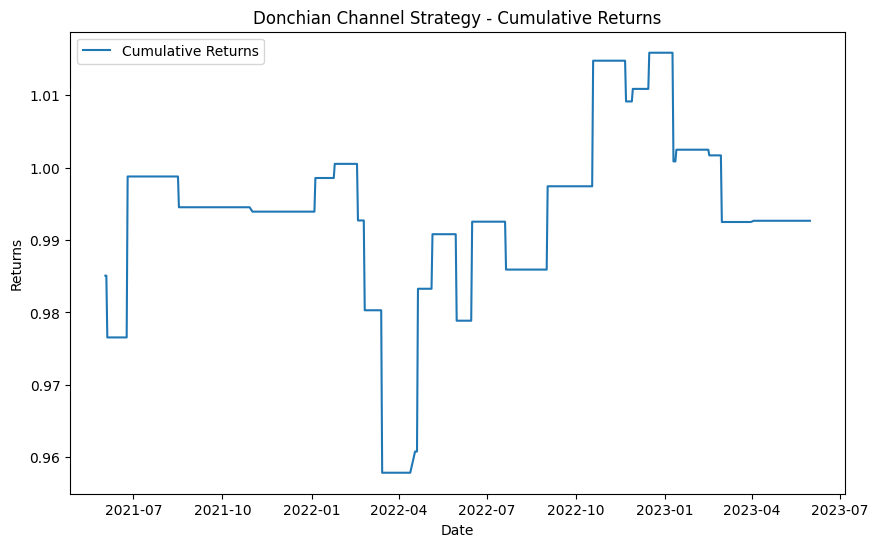

In [9]:
# Calculate returns based on the Donchian Channel strategy
stock_data['Returns'] = stock_data['Close'].pct_change()
stock_data['StrategyReturns'] = stock_data['Returns'] * stock_data['Signal'].shift()
stock_data['CumulativeReturns'] = (1 + stock_data['StrategyReturns']).cumprod()

# Plotting the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['CumulativeReturns'], label='Cumulative Returns')
plt.title('Donchian Channel Strategy - Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


In [10]:
def calculate_rsi(data, window):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(rsi_window).mean()
    avg_loss = loss.rolling(rsi_window).mean()
    relative_strength = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + relative_strength))
    return rsi
rsi_window = 14
buy_threshold = 30
sell_threshold = 70
def rsi_strategy(stock_data, rsi_window, buy_threshold, sell_threshold):
    stock_data['RSI'] = calculate_rsi(stock_data['Close'], rsi_window)
    stock_data['Buy'] = 0
    stock_data['Sell'] = 0
    prev_signal = 0
    for i in range(1, len(stock_data)):
        if ((stock_data['RSI'][i] < buy_threshold) and (prev_signal != 1)):
            stock_data['Buy'][i] = 1
            prev_signal = 1
        elif ((stock_data['RSI'][i] > sell_threshold) and (prev_signal != -1)):
            stock_data['Sell'][i] = -1
            prev_signal = -1

    stock_data['Signal'] = stock_data['Buy'] + stock_data['Sell']
    stock_data['Position'] = stock_data['Signal'].cumsum()
    return stock_data

C:\Users\monid\AppData\Local\Temp\ipykernel_16700\1326834561.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Buy'][i] = 1
C:\Users\monid\AppData\Local\Temp\ipykernel_16700\1326834561.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Sell'][i] = -1


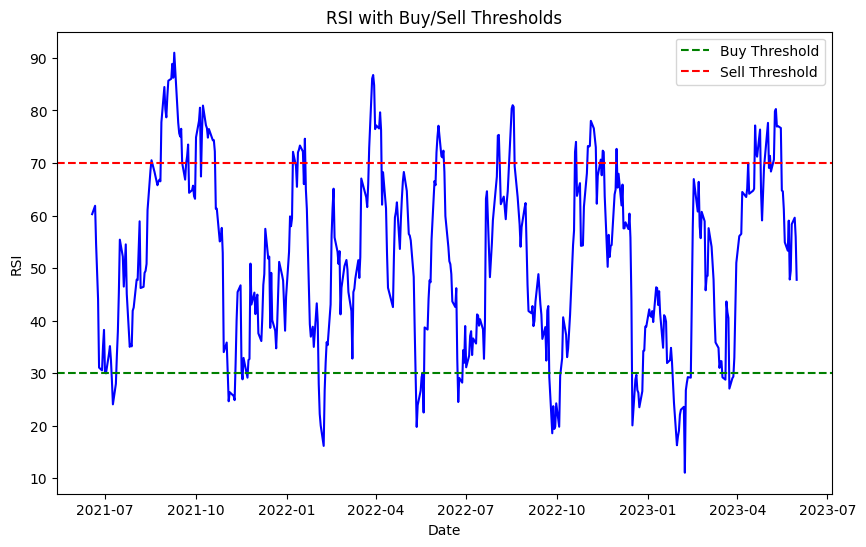

In [11]:
df_with_signals = rsi_strategy(stock_data, rsi_window, buy_threshold, sell_threshold)

# Plotting RSI values
plt.figure(figsize=(10, 6))
plt.plot(df_with_signals.index, df_with_signals['RSI'], color='blue')
plt.axhline(y=buy_threshold, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(y=sell_threshold, color='red', linestyle='--', label='Sell Threshold')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('RSI with Buy/Sell Thresholds')
plt.legend()
plt.show()




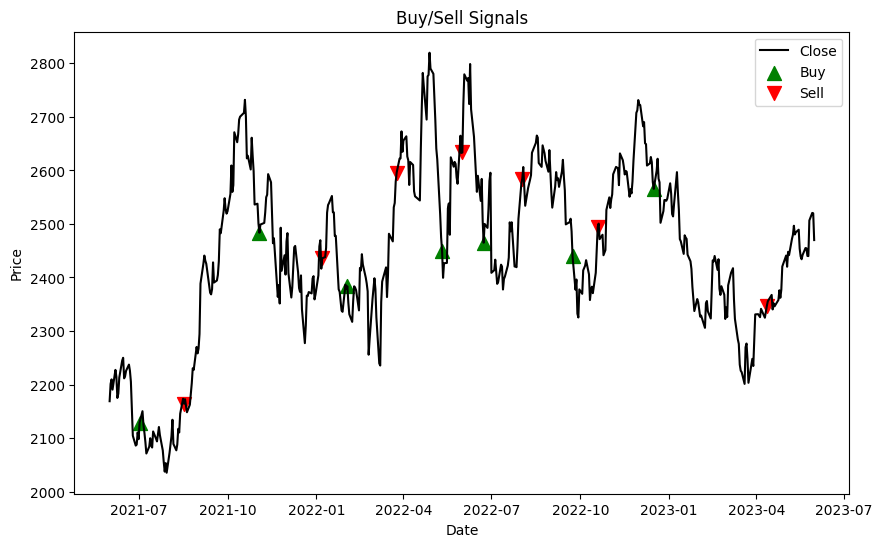

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df_with_signals.index, df_with_signals['Close'], color='black', label='Close')
plt.scatter(df_with_signals[df_with_signals['Buy'] == 1].index,
            df_with_signals[df_with_signals['Buy'] == 1]['Close'],
            color='green', marker='^', label='Buy', s=100)
plt.scatter(df_with_signals[df_with_signals['Sell'] == -1].index,
            df_with_signals[df_with_signals['Sell'] == -1]['Close'],
            color='red', marker='v', label='Sell', s=100)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy/Sell Signals')
plt.legend()
plt.show()


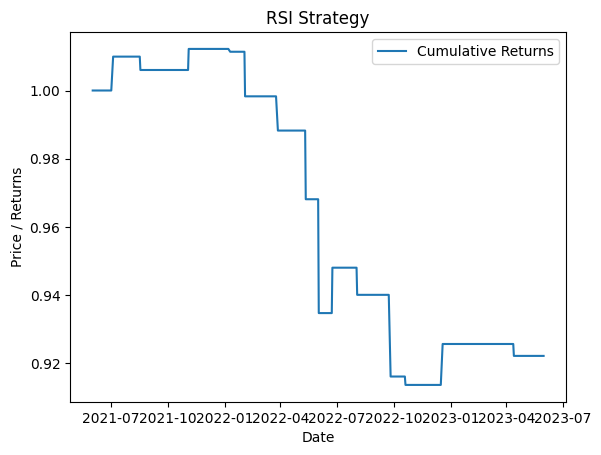

In [13]:
#returns
def calculate_returns(stock_data):
    stock_data['Returns'] = stock_data['Close'].pct_change()
    stock_data['StrategyReturns'] = stock_data['Returns'] * stock_data['Signal'].shift()
    stock_data['CumulativeReturns'] = (1 + stock_data['StrategyReturns']).cumprod()
    return stock_data
data_with_returns = calculate_returns(stock_data)

# Access the calculated returns
returns = data_with_returns['StrategyReturns']
cumulative_returns = data_with_returns['CumulativeReturns']

plt.plot(data_with_returns['CumulativeReturns'], label='Cumulative Returns')

# Customizing the plot
plt.title('RSI Strategy')
plt.xlabel('Date')
plt.ylabel('Price / Returns')
plt.legend()

# Displaying the plot
plt.show()

In [14]:
stock_name="DELTACORP.NS"
start_date = "2021-06-01"  
end_date = "2023-06-01"


In [15]:
stock_data=yf.download(stock_name,start_date,end_date)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-01,170.050003,171.399994,166.550003,168.949997,166.940506,1886597
2021-06-02,169.000000,176.449997,167.000000,175.649994,173.560806,5016267
2021-06-03,176.800003,180.500000,176.350006,177.699997,175.586426,3260454
2021-06-04,177.800003,186.500000,177.050003,185.250000,183.046631,7380067
2021-06-07,186.699997,195.899994,183.449997,188.850006,186.603806,7824563


In [16]:
window = 10  # Specify the window size for the Donchian Channel
stock_data['high_channel'] = stock_data['High'].rolling(window=window, min_periods=1).max()
stock_data['low_channel'] = stock_data['Low'].rolling(window=window, min_periods=1).min()

# Initialize trading signals list
signals = []

# Generate trading signals based on Donchian Channel breakout
previous_signal = 0
for i in range(len(stock_data)):
    if stock_data['Close'][i] > stock_data['high_channel'][i-1]:
        if previous_signal != 1:  # Ensure breakout from previous sell signal
            signals.append(1)  # Buy signal
            previous_signal = 1
        else:
            signals.append(0)  # No signal
    elif stock_data['Close'][i] < stock_data['low_channel'][i-1]:
        if previous_signal != -1:  # Ensure breakout from previous buy signal
            signals.append(-1)  # Sell signal
            previous_signal = -1
        else:
            signals.append(0)  # No signal
    else:
        signals.append(0)  # No signal

# Add the trading signals to the DataFrame
stock_data['Signal'] = signals

# Print the DataFrame with the trading signals
print(stock_data)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-06-01  170.050003  171.399994  166.550003  168.949997  166.940506   
2021-06-02  169.000000  176.449997  167.000000  175.649994  173.560806   
2021-06-03  176.800003  180.500000  176.350006  177.699997  175.586426   
2021-06-04  177.800003  186.500000  177.050003  185.250000  183.046631   
2021-06-07  186.699997  195.899994  183.449997  188.850006  186.603806   
...                ...         ...         ...         ...         ...   
2023-05-25  233.649994  240.449997  232.800003  236.800003  236.800003   
2023-05-26  237.500000  244.800003  235.050003  236.000000  236.000000   
2023-05-29  237.800003  242.000000  233.949997  240.500000  240.500000   
2023-05-30  241.000000  244.000000  239.649994  241.050003  241.050003   
2023-05-31  239.899994  243.000000  236.100006  242.600006  242.600006   

             Volume  high_channel  lo

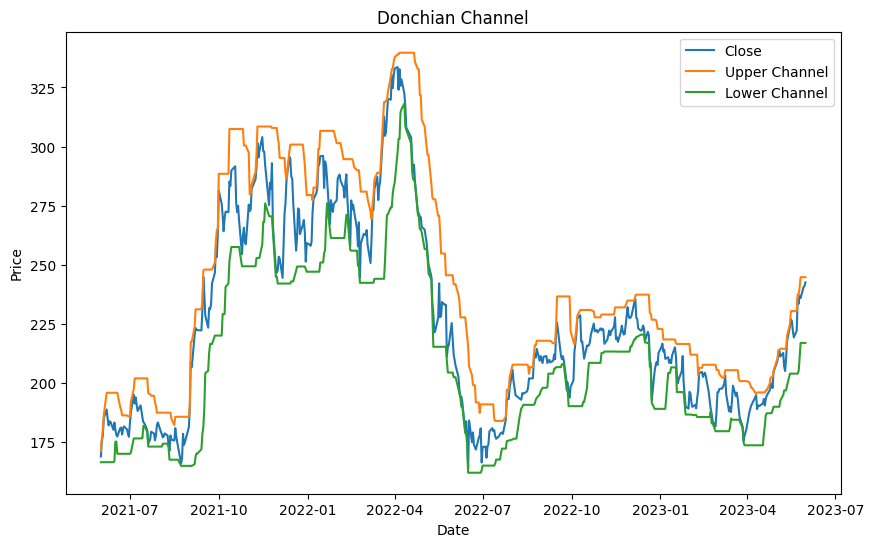

In [17]:
#plotting the dunchian channel indicator
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close')
plt.plot(stock_data.index, stock_data['high_channel'], label='Upper Channel')
plt.plot(stock_data.index, stock_data['low_channel'], label='Lower Channel')
plt.title('Donchian Channel')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



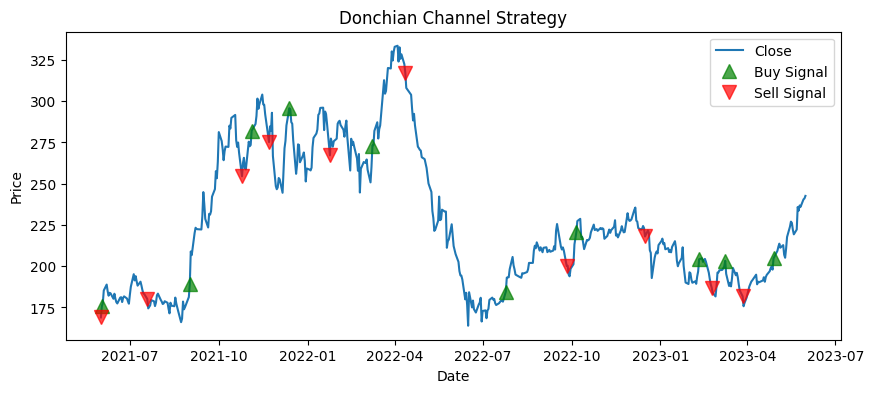

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(stock_data.index, stock_data['Close'], label='Close')
plt.plot(stock_data[stock_data['Signal'] == 1].index, stock_data[stock_data['Signal'] == 1]['Close'],
         '^', markersize=10, color='g', label='Buy Signal', alpha=0.7)
plt.plot(stock_data[stock_data['Signal'] == -1].index, stock_data[stock_data['Signal'] == -1]['Close'],
         'v', markersize=10, color='r', label='Sell Signal', alpha=0.7)
plt.title('Donchian Channel Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

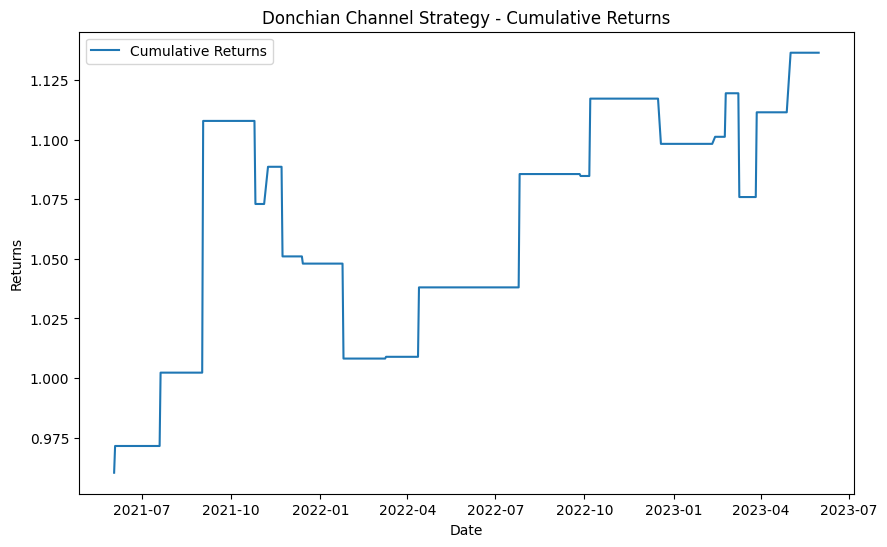

In [19]:
# Calculate returns based on the Donchian Channel strategy
stock_data['Returns'] = stock_data['Close'].pct_change()
stock_data['StrategyReturns'] = stock_data['Returns'] * stock_data['Signal'].shift()
stock_data['CumulativeReturns'] = (1 + stock_data['StrategyReturns']).cumprod()

# Plotting the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['CumulativeReturns'], label='Cumulative Returns')
plt.title('Donchian Channel Strategy - Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


In [20]:
def calculate_rsi(data, window):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(rsi_window).mean()
    avg_loss = loss.rolling(rsi_window).mean()
    relative_strength = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + relative_strength))
    return rsi
rsi_window = 14
buy_threshold = 30
sell_threshold = 70
def rsi_strategy(stock_data, rsi_window, buy_threshold, sell_threshold):
    stock_data['RSI'] = calculate_rsi(stock_data['Close'], rsi_window)
    stock_data['Buy'] = 0
    stock_data['Sell'] = 0
    prev_signal = 0
    for i in range(1, len(stock_data)):
        if ((stock_data['RSI'][i] < buy_threshold) and (prev_signal != 1)):
            stock_data['Buy'][i] = 1
            prev_signal = 1
        elif ((stock_data['RSI'][i] > sell_threshold) and (prev_signal != -1)):
            stock_data['Sell'][i] = -1
            prev_signal = -1

    stock_data['Signal'] = stock_data['Buy'] + stock_data['Sell']
    stock_data['Position'] = stock_data['Signal'].cumsum()
    return stock_data

C:\Users\monid\AppData\Local\Temp\ipykernel_16700\1326834561.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Buy'][i] = 1
C:\Users\monid\AppData\Local\Temp\ipykernel_16700\1326834561.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Sell'][i] = -1


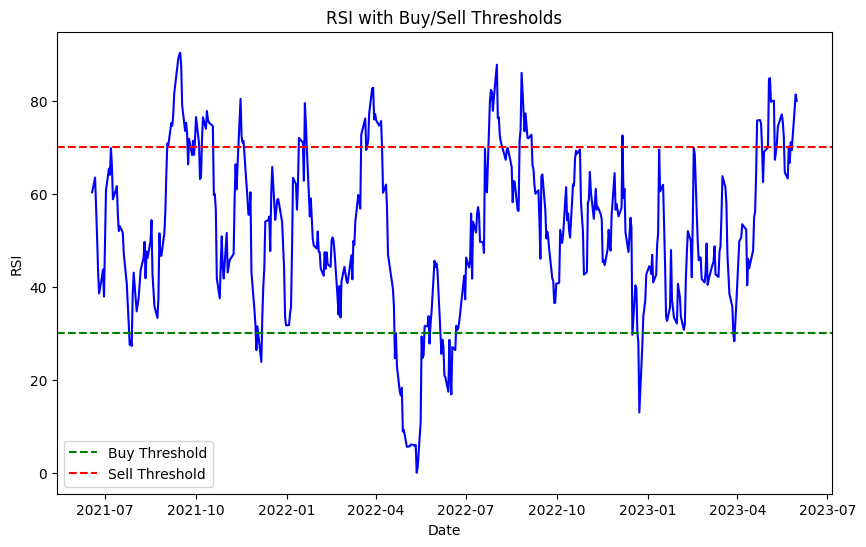

In [21]:
df_with_signals = rsi_strategy(stock_data, rsi_window, buy_threshold, sell_threshold)

# Plotting RSI values
plt.figure(figsize=(10, 6))
plt.plot(df_with_signals.index, df_with_signals['RSI'], color='blue')
plt.axhline(y=buy_threshold, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(y=sell_threshold, color='red', linestyle='--', label='Sell Threshold')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('RSI with Buy/Sell Thresholds')
plt.legend()
plt.show()




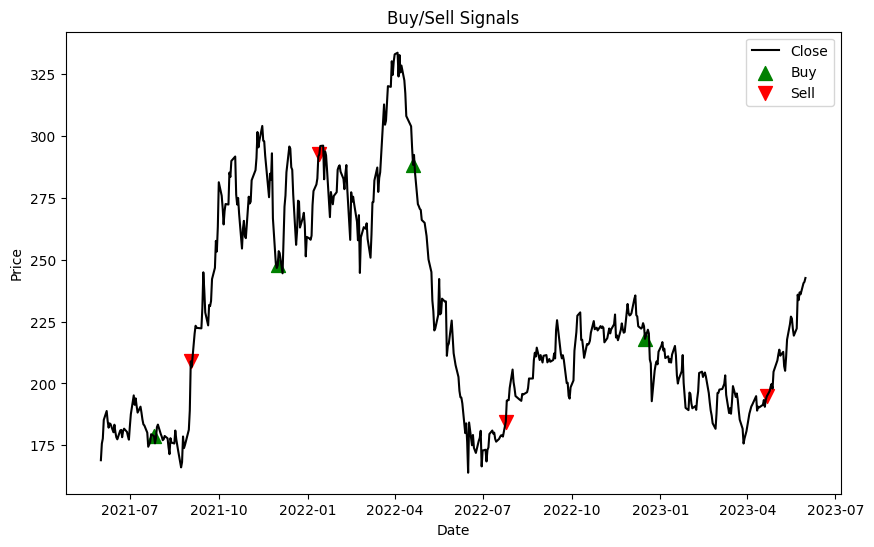

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df_with_signals.index, df_with_signals['Close'], color='black', label='Close')
plt.scatter(df_with_signals[df_with_signals['Buy'] == 1].index,
            df_with_signals[df_with_signals['Buy'] == 1]['Close'],
            color='green', marker='^', label='Buy', s=100)
plt.scatter(df_with_signals[df_with_signals['Sell'] == -1].index,
            df_with_signals[df_with_signals['Sell'] == -1]['Close'],
            color='red', marker='v', label='Sell', s=100)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy/Sell Signals')
plt.legend()
plt.show()


In [23]:
def calculate_returns(stock_data):
    stock_data['Returns'] = stock_data['Close'].pct_change()
    stock_data['StrategyReturns'] = stock_data['Returns'] * stock_data['Signal'].shift()
    stock_data['CumulativeReturns'] = (1 + stock_data['StrategyReturns']).cumprod()
    return stock_data
data_with_returns = calculate_returns(stock_data)

# Access the calculated returns
returns = data_with_returns['StrategyReturns']
cumulative_returns = data_with_returns['CumulativeReturns']

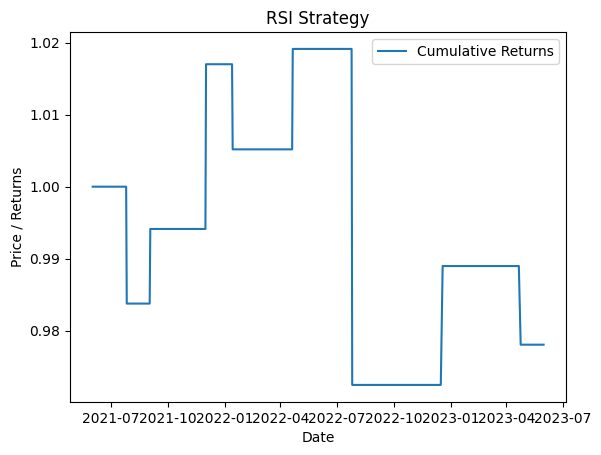

In [24]:
plt.plot(data_with_returns['CumulativeReturns'], label='Cumulative Returns')

# Customizing the plot
plt.title('RSI Strategy')
plt.xlabel('Date')
plt.ylabel('Price / Returns')
plt.legend()

# Displaying the plot
plt.show()

In [25]:
def combined_strategy(stock_data, rsi_window, buy_threshold, sell_threshold, donchian_window):
    stock_data['RSI'] = calculate_rsi(stock_data['Close'], rsi_window)
    stock_data['Buy'] = 0
    stock_data['Sell'] = 0
    prev_signal = 0
    
    # Donchian Channel signals
    stock_data['high_channel'] = stock_data['High'].rolling(window=donchian_window, min_periods=1).max()
    stock_data['low_channel'] = stock_data['Low'].rolling(window=donchian_window, min_periods=1).min()
    
    for i in range(1, len(stock_data)):
        # RSI signals
        if ((stock_data['RSI'][i] < buy_threshold) and (prev_signal != 1)):
            stock_data['Buy'][i] = 1
            prev_signal = 1
        elif ((stock_data['RSI'][i] > sell_threshold) and (prev_signal != -1)):
            stock_data['Sell'][i] = -1
            prev_signal = -1
        
        # Donchian Channel signals
        if stock_data['Close'][i] > stock_data['high_channel'][i-1]:
            if prev_signal != 1:  # Ensure breakout from previous sell signal
                stock_data['Buy'][i] = 1  # Buy signal
                prev_signal = 1
        elif stock_data['Close'][i] < stock_data['low_channel'][i-1]:
            if prev_signal != -1:  # Ensure breakout from previous buy signal
                stock_data['Sell'][i] = -1  # Sell signal
                prev_signal = -1

    stock_data['Signal'] = stock_data['Buy'] + stock_data['Sell']
    stock_data['Position'] = stock_data['Signal'].cumsum()
    return stock_data


C:\Users\monid\AppData\Local\Temp\ipykernel_16700\497779852.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Buy'][i] = 1  # Buy signal
C:\Users\monid\AppData\Local\Temp\ipykernel_16700\497779852.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Sell'][i] = -1  # Sell signal
C:\Users\monid\AppData\Local\Temp\ipykernel_16700\497779852.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Buy'][i

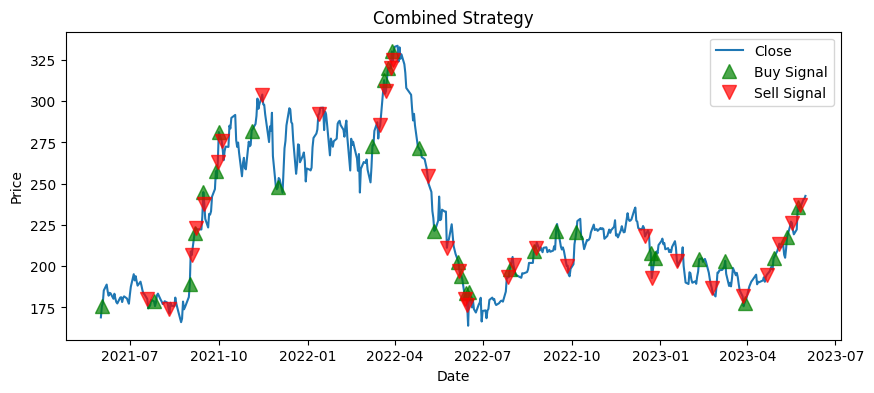

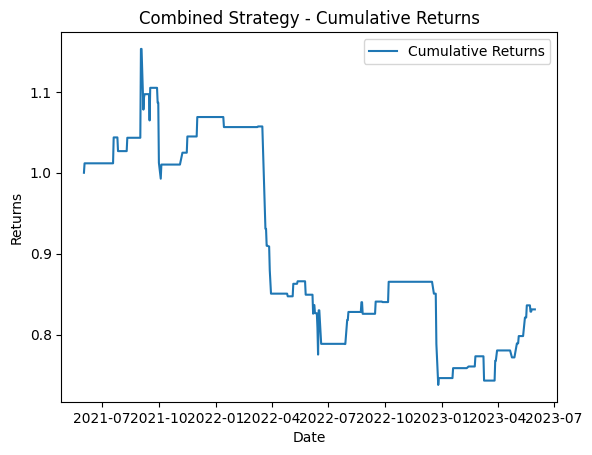

In [26]:
# Assuming you have the stock_data DataFrame containing the necessary data
rsi_window = 14
buy_threshold = 30
sell_threshold = 70
donchian_window = 10

# Apply combined strategy
combined_data = combined_strategy(stock_data, rsi_window, buy_threshold, sell_threshold, donchian_window)

# Plotting the combined signals
plt.figure(figsize=(10, 4))
plt.plot(combined_data.index, combined_data['Close'], label='Close')
plt.plot(combined_data[combined_data['Signal'] == 1].index, combined_data[combined_data['Signal'] == 1]['Close'],
         '^', markersize=10, color='g', label='Buy Signal', alpha=0.7)
plt.plot(combined_data[combined_data['Signal'] == -1].index, combined_data[combined_data['Signal'] == -1]['Close'],
         'v', markersize=10, color='r', label='Sell Signal', alpha=0.7)
plt.title('Combined Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate returns based on the combined strategy
data_with_returns = calculate_returns(combined_data)

# Access the calculated returns
returns = data_with_returns['StrategyReturns']
cumulative_returns = data_with_returns['CumulativeReturns']

# Plot the cumulative returns
plt.plot(data_with_returns['CumulativeReturns'], label='Cumulative Returns')
plt.title('Combined Strategy - Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()
